In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (15,6)
plt.style.use('ggplot')

# Machine Learning for Time Series

Dans cette section, nous nous intéressons à l'application des méthodes de machine learning dites "classiques" afin de réaliser le forecast d'une série temporelle. 

In [4]:
df = pd.read_csv('data_monthly_champagne_sales.csv', parse_dates=['Month'])
df.columns = ['Temps', 'Ventes']
df.set_index('Temps', inplace=True)
df.head()

,Ventes
Temps,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


Text(0, 0.5, 'Ventes')

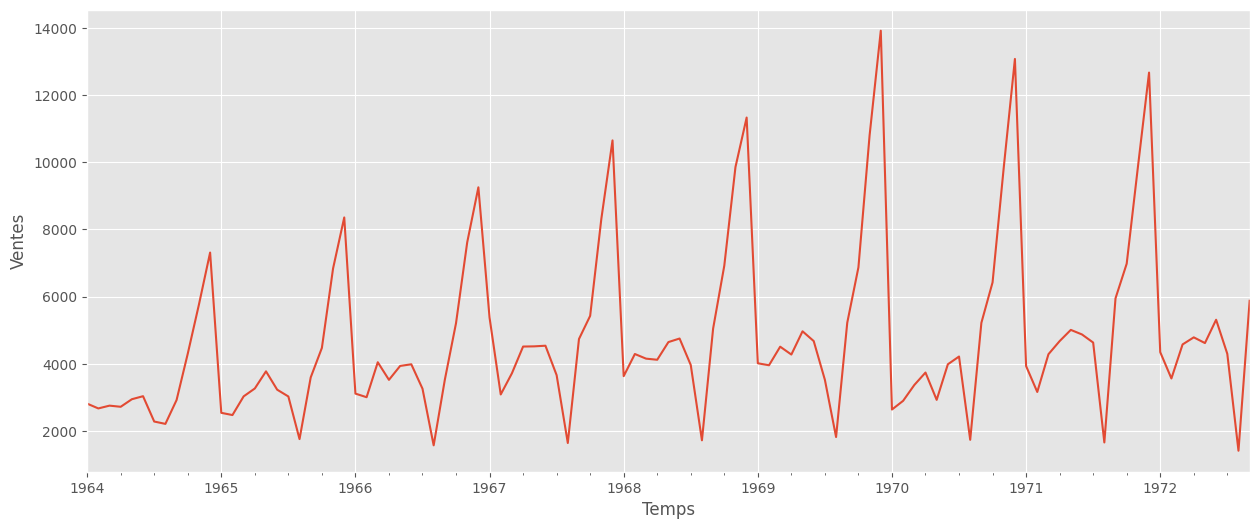

In [5]:
df.Ventes.plot()
plt.xlabel('Temps')
plt.ylabel('Ventes')

---

## Basic Feature Engineering
Comme l'objectif de cette section n'est pas le feature engineering, nous garderons cette partie aussi simple que possible (pour aller plus loin, voir le TP dédié). Nous allons créer des features habituellement utilisées en séries temporelles: le mois, l'année, et les lags.

In [ ]:
df.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Temps', length=105, freq=None)

La date de cutoff est fixée de telle sorte à laisser 12 mois de données après cette date. 

L'objectif est ainsi de prédire les ventes pour les 12 derniers mois du jeu de données.

Nous illustrerons 2 approches possibles ici.

**Première approche** : Nous utilisons un seul modèle, ce qui limitera le plus petit lag autorisé au lag 12. 

**Deuxième approche** : Approche "Directe". Pour avoir accès aux lags inférieurs, il sera possible de créer 12 modèles, ce qui autorisera pour l'horizon t+1 l'utilisation du lag 1, pout l'horizon t+2 l'utilisation du lag 2, etc. 

Nous n'illustrerons pas ici l'approche récursive et l'approche hybride DirRec. 

Cela illustre bien le compromis entre le nombre de modèles et le nombre de prédicteurs de type lags que l'on peut inclure dans un modèle ML. En effet, le lag -1 est très souvent explicatif, mais bien entendu il n'est pas disponible lorsque l'on souhaite prédire à un horizon au dela de t+1. 

## Utilisation d'un seul modèle avec un lag mini autorisé de 12

Création des lags

In [ ]:
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Lag_24'] = df.Ventes.shift(24)
df['Lag_23'] = df.Ventes.shift(23)
df['Lag_18'] = df.Ventes.shift(18)
df['Lag_15'] = df.Ventes.shift(15)
df['Lag_13'] = df.Ventes.shift(13)
df['Lag_12'] = df.Ventes.shift(12)

Séparation train test

In [ ]:
horizons = 12
split_point = df.shape[0]-horizons
train, test = df[24:split_point], df[split_point:]

In [ ]:
X_train = train[df.columns[1:]]
y_train = train['Ventes']
X_test = test[df.columns[1:]]
y_test = test['Ventes']

Random forest regressor

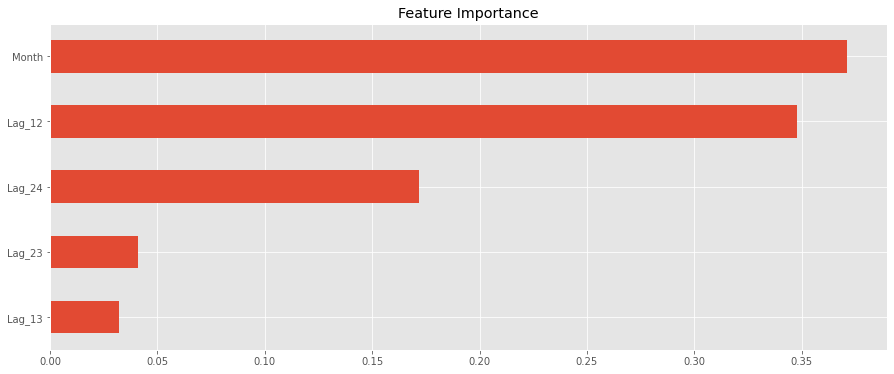

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).sort_values().plot(kind='barh', title='Feature Importance');

MSE = 399394.95


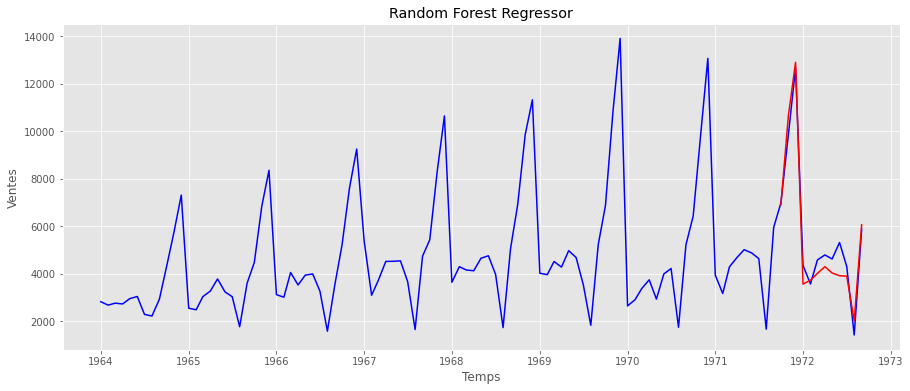

In [ ]:
from sklearn.metrics import mean_squared_error

perf_summary=dict()

MSE = mean_squared_error(y_test, y_pred)
print("MSE = %.2f"%MSE)
perf_summary['RF 1 modèle lag 12'] = MSE

plt.plot(df.index, df.Ventes, c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred, c='r', label='Random Forest Regressor')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Random Forest Regressor')
plt.show()

## Benchmark moyenne des 24 derniers mois

In [ ]:
forecast = np.mean(train['Ventes'][-24:])
y_pred_mean = np.ones(12,)*forecast
y_pred_mean

array([5410.625, 5410.625, 5410.625, 5410.625, 5410.625, 5410.625,
       5410.625, 5410.625, 5410.625, 5410.625, 5410.625, 5410.625])

MSE benchmark naïf= 8214812.37
MSE RF= 399394.95


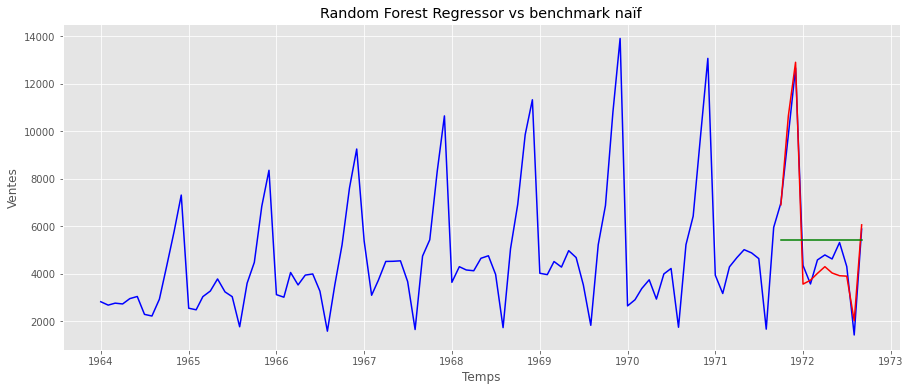

In [ ]:
MSE = mean_squared_error(y_test, y_pred_mean)
print("MSE benchmark naïf= %.2f"%MSE)
perf_summary['Naive mean 24 months'] = MSE

MSE = mean_squared_error(y_test, y_pred)
print("MSE RF= %.2f"%MSE)

plt.plot(df.index, df.Ventes, c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred, c='r', label='Random Forest Regressor')
plt.plot(X_test.index, y_pred_mean, c='g', label='Benchmark moyenne 24 mois')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Random Forest Regressor vs benchmark naïf')
plt.show()

Benchmark seasonal naïve

In [ ]:
#seasonal naive 
y_pred_seas = train['Ventes'][-12:]
y_pred_seas

Temps
1970-10-01     6424
1970-11-01     9842
1970-12-01    13076
1971-01-01     3934
1971-02-01     3162
1971-03-01     4286
1971-04-01     4676
1971-05-01     5010
1971-06-01     4874
1971-07-01     4633
1971-08-01     1659
1971-09-01     5951
Name: Ventes, dtype: int64

MSE benchmark seasonal naive= 119093.00
MSE RF= 399394.95


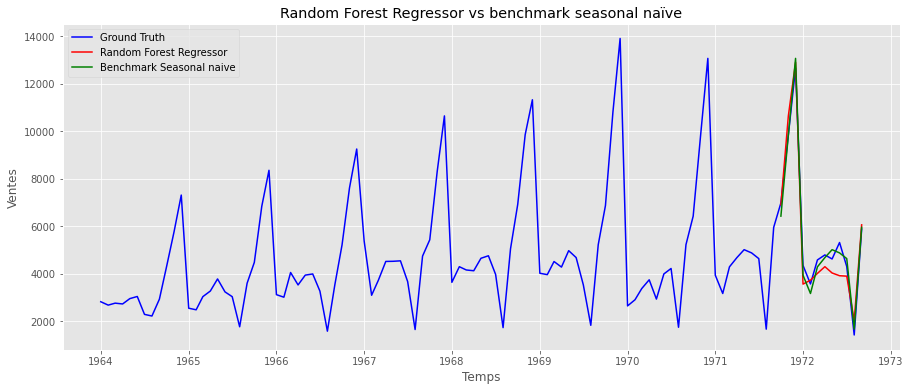

In [ ]:
MSE = mean_squared_error(y_test, y_pred_seas)
print("MSE benchmark seasonal naive= %.2f"%MSE)
perf_summary['Seasonal naive'] = MSE

MSE = mean_squared_error(y_test, y_pred)
print("MSE RF= %.2f"%MSE)

plt.plot(df.index, df.Ventes, c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred, c='r', label='Random Forest Regressor')
plt.plot(X_test.index, y_pred_seas, c='g', label='Benchmark Seasonal naive')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Random Forest Regressor vs benchmark seasonal naïve')
plt.legend()
plt.show()


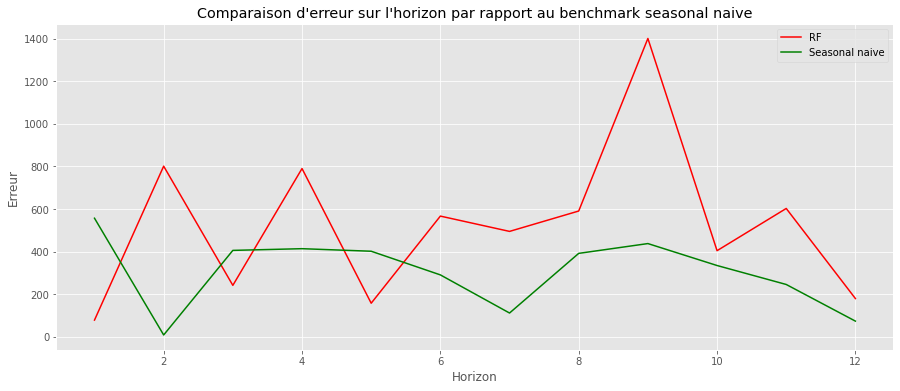

In [ ]:
plt.plot(np.arange(1,13,1), np.abs(df.Ventes[-12:].values-y_pred[-12:]), c='r', label='RF')
plt.plot(np.arange(1,13,1), np.abs(df.Ventes[-12:].values-y_pred_seas), c='g', label='Seasonal naive')

plt.xlabel('Horizon')
plt.ylabel('Erreur')
plt.title("Comparaison d'erreur sur l'horizon par rapport au benchmark seasonal naive")
plt.legend()
plt.show()

## Approche directe

In [ ]:
df = pd.read_csv('data_monthly_champagne_sales.csv', parse_dates=['Month'])
df.columns = ['Temps', 'Ventes']
df.set_index('Temps', inplace=True)
df.head()

df['Month'] = df.index.month
df['Year'] = df.index.year
df['Lag_24'] = df.Ventes.shift(24)
df['Lag_23'] = df.Ventes.shift(23)
df['Lag_18'] = df.Ventes.shift(18)
df['Lag_15'] = df.Ventes.shift(15)
df['Lag_13'] = df.Ventes.shift(13)
df['Lag_12'] = df.Ventes.shift(12)

# automatisation de la création des lags
for lag in np.arange(11,0,-1):
  df['Lag_'+str(lag)] = df.Ventes.shift(lag)

df.head()

,Ventes,Month,Year,Lag_24,Lag_23,Lag_18,Lag_15,Lag_13,Lag_12,Lag_11,Lag_10,Lag_9,Lag_8,Lag_7,Lag_6,Lag_5,Lag_4,Lag_3,Lag_2,Lag_1
Temps,,,,,,,,,,,,,,,,,,,,
1964-01-01,2815,1,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-01,2672,2,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2815.0
1964-03-01,2755,3,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2815.0,2672.0
1964-04-01,2721,4,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2815.0,2672.0,2755.0
1964-05-01,2946,5,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2815.0,2672.0,2755.0,2721.0


In [ ]:
df.shape

(105, 20)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# approche directe 
horizons = 12
cutoff_index = df.shape[0]-horizons

predictions = []
pred_index = []
y_true = []
for h in np.arange(1,horizons+1,1):

  train, test = df[24:cutoff_index], df[cutoff_index:cutoff_index+h]
  if h != 1:
    print("Horizon: ", h)
    print("Columns: ", df.columns[1:-h+1])
    print("")
    X_train = train[df.columns[1:-h+1]]
    X_test = test[df.columns[1:-h+1]]
  else : 
    print("Horizon: ", h)
    print("Columns: ", df.columns[1:])
    X_train = train[df.columns[1:]]
    X_test = test[df.columns[1:]]

  y_train = train['Ventes']
  y_test = test['Ventes']

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  predictions.append(y_pred[h-1])
  pred_index.append(X_test.index[h-1])
  y_true.append(y_test[h-1])

MSE = mean_squared_error(y_true, predictions)
print("MSE = %.2f"%MSE)
perf_summary['RF Approche directe - 12 modèles'] = MSE


Horizon:  1
Columns:  Index(['Month', 'Year', 'Lag_24', 'Lag_23', 'Lag_18', 'Lag_15', 'Lag_13',
       'Lag_12', 'Lag_11', 'Lag_10', 'Lag_9', 'Lag_8', 'Lag_7', 'Lag_6',
       'Lag_5', 'Lag_4', 'Lag_3', 'Lag_2', 'Lag_1'],
      dtype='object')
Horizon:  2
Columns:  Index(['Month', 'Year', 'Lag_24', 'Lag_23', 'Lag_18', 'Lag_15', 'Lag_13',
       'Lag_12', 'Lag_11', 'Lag_10', 'Lag_9', 'Lag_8', 'Lag_7', 'Lag_6',
       'Lag_5', 'Lag_4', 'Lag_3', 'Lag_2'],
      dtype='object')

Horizon:  3
Columns:  Index(['Month', 'Year', 'Lag_24', 'Lag_23', 'Lag_18', 'Lag_15', 'Lag_13',
       'Lag_12', 'Lag_11', 'Lag_10', 'Lag_9', 'Lag_8', 'Lag_7', 'Lag_6',
       'Lag_5', 'Lag_4', 'Lag_3'],
      dtype='object')

Horizon:  4
Columns:  Index(['Month', 'Year', 'Lag_24', 'Lag_23', 'Lag_18', 'Lag_15', 'Lag_13',
       'Lag_12', 'Lag_11', 'Lag_10', 'Lag_9', 'Lag_8', 'Lag_7', 'Lag_6',
       'Lag_5', 'Lag_4'],
      dtype='object')

Horizon:  5
Columns:  Index(['Month', 'Year', 'Lag_24', 'Lag_23', 'Lag_18',

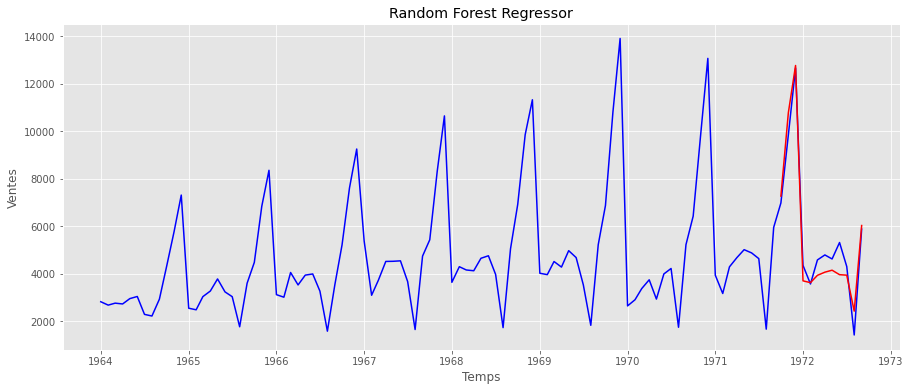

In [ ]:
plt.plot(df.index, df.Ventes, c='b', label='Ground Truth')
plt.plot(pred_index, predictions, c='r', label='Random Forest Regressor')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Random Forest Regressor')
plt.show()

Comparaison des deux approches



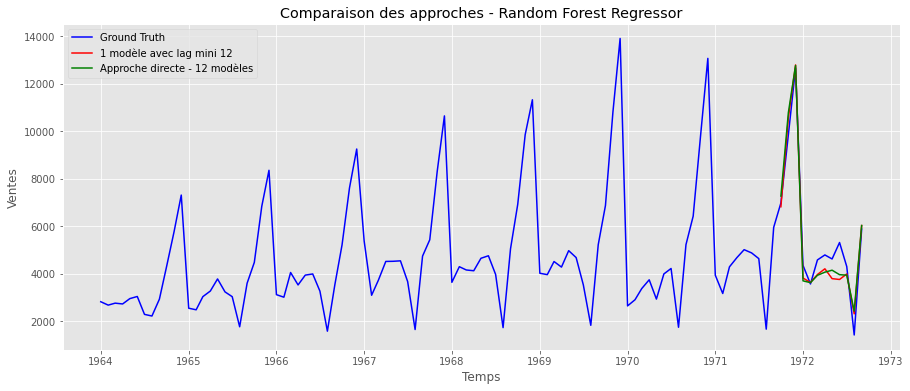

In [ ]:
plt.plot(df.index, df.Ventes, c='b', label='Ground Truth')
plt.plot(X_test.index, y_pred, c='r', label='1 modèle avec lag mini 12')
plt.plot(pred_index, predictions, c='g', label='Approche directe - 12 modèles')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Comparaison des approches - Random Forest Regressor')
plt.legend()
plt.show()

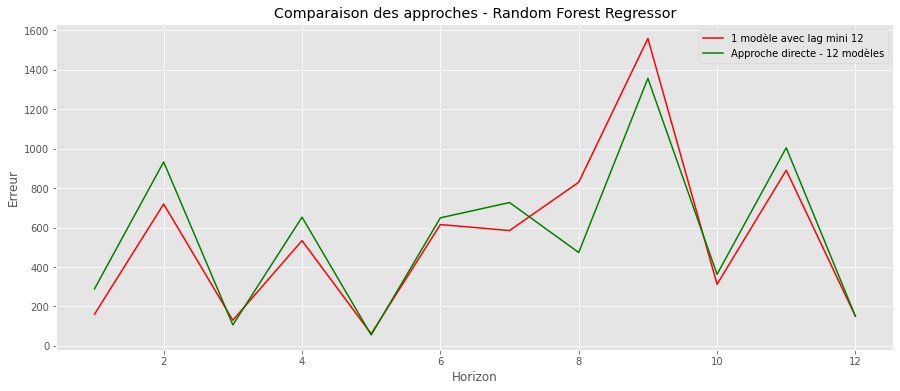

In [ ]:
plt.plot(np.arange(1,13,1), np.abs(df.Ventes[-12:].values-y_pred[-12:]), c='r', label='1 modèle avec lag mini 12')
plt.plot(np.arange(1,13,1), np.abs(df.Ventes[-12:].values-predictions), c='g', label='Approche directe - 12 modèles')

plt.xlabel('Horizon')
plt.ylabel('Erreur')
plt.title('Comparaison des approches - Random Forest Regressor')
plt.legend()
plt.show()

# Benchmark avec un modèle linéaire
Linear Regression

In [ ]:
import statsmodels.formula.api as sm

model = sm.ols(formula='Ventes ~ Year +  Lag_24 + Lag_18 + Lag_15 + Lag_12 + C(Month)', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ventes   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     81.54
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           3.03e-36
Time:                        14:23:58   Log-Likelihood:                -629.72
No. Observations:                  81   AIC:                             1293.
Df Residuals:                      64   BIC:                             1334.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.763e+05   1.26e+05     -1.404      0.165   -4.27e+05    7.45e+04
C(Month)[T.2]     49.2230    449.660      0.109      0.913    -849.076     947.521
C(Month)[T.3]    713.5266    562.726      1.268      0.209    -410.647    1837.700
C(Month)[T.4]    -66.1185    440.662     -0.150      0.881    -946.443     814.206
C(Month)[T.5]    -93.7322    605.355     -0.155      0.877   -1303.067    1115.603
C(Month)[T.6]    154.7658    740.789      0.209      0.835   -1325.131    1634.662
C(Month)[T.7]   -171.7823    376.429     -0.456      0.650    -923.785     580.220
C(Month)[T.8]  -1583.1004    418.550     -3.782      0.000   -2419.251    -746.950
C(Month)[T.9]    580.9539    388.536      1.495      0.140    -195.236    1357.143
C(Month)[T.10]  1257.9189    481.224      2.614      0.011     296.564    2219.274
C(Month)[T.11]  2832.9059    766.987      3.694      0.000    1300.674    4365.138
C(Month)[T.12]  4685.5544    896.364      5.227      0.000    2894.861    6476.248
Year              91.0378     64.035      1.422      0.160     -36.887     218.963
Lag_24             0.1437      0.107      1.343      0.184      -0.070       0.357
Lag_18             0.0090      0.088      0.103      0.918      -0.166       0.184
Lag_15            -0.1228      0.089     -1.384      0.171      -0.300       0.054
Lag_12             0.2946      0.116      2.551      0.013       0.064       0.525
==============================================================================
Omnibus:                        9.706   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               20.625
Skew:                           0.251   Prob(JB):                     3.32e-05
Kurtosis:                       5.420   Cond. No.                     1.75e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MSE = 83800.41


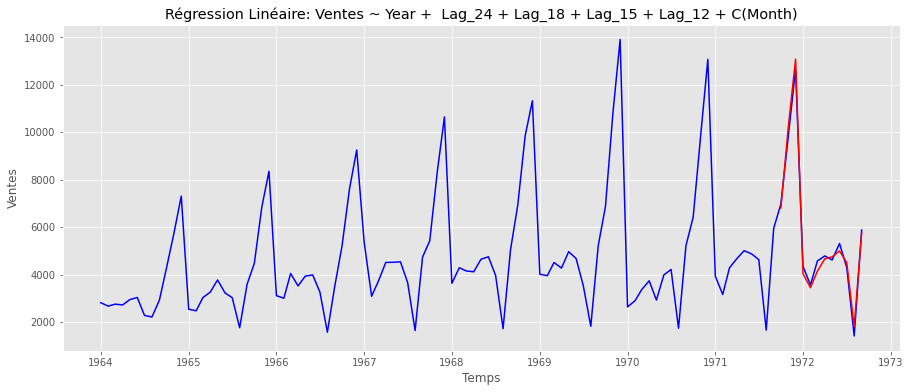

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred_lin = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred_lin)
print("MSE = %.2f"%MSE)
perf_summary['Regression Lineaire'] = MSE


plt.plot(df.index, df.Ventes, c='b')
plt.plot(X_test.index, y_pred_lin, c='r')

plt.xlabel('Temps')
plt.ylabel('Ventes')
plt.title('Régression Linéaire: Ventes ~ Year +  Lag_24 + Lag_18 + Lag_15 + Lag_12 + C(Month)')
plt.show()

In [ ]:
df_perf=pd.DataFrame.from_dict(perf_summary, orient='index', columns=['MSE'])


In [ ]:
df_perf

,MSE
RF 1 modèle lag 12,3.993949e+05
Naive mean 24 months,8.214812e+06
Seasonal naive,1.190930e+05
RF Approche directe - 12 modèles,4.642344e+05
Regression Lineaire,8.380041e+04


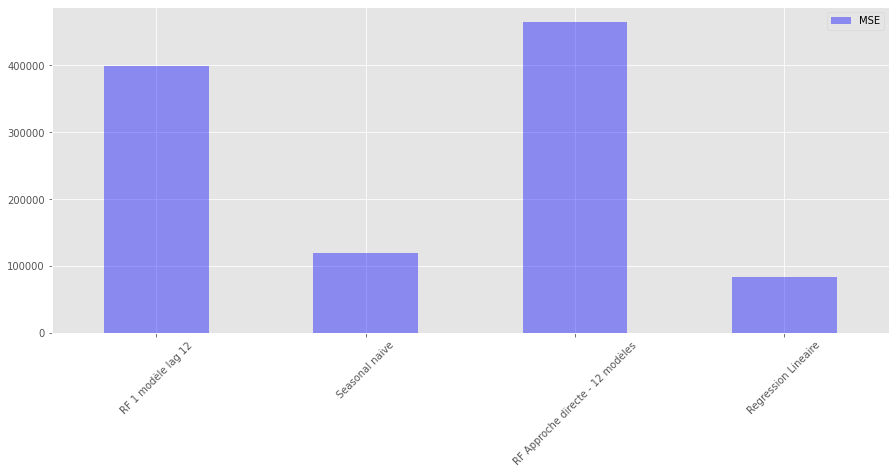

In [ ]:
df_perf[df_perf.index !='Naive mean 24 months'].plot(kind='bar', alpha=0.4, rot=45, color='b')
